`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


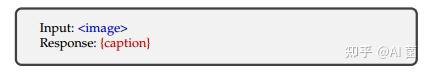

In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import os
import requests
from PIL import Image
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "/data/model/Qwen/Qwen2-VL-2B-Instruct-AWQ", device_map="auto"
)
processor = AutoProcessor.from_pretrained("/data/model/Qwen/Qwen2-VL-2B-Instruct-AWQ")

# Image
url_1 = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image_1 = Image.open(requests.get(url_1, stream=True).raw)
url_2 = "https://pic2.zhimg.com/v2-284d76d52cc507a0637ee06913aa07bf_1440w.jpg"
image_2 = Image.open(requests.get(url_2, stream=True).raw)

image_2

In [28]:
# Messages containing multiple images and a text query
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "1."},
            {"type": "image"},
            {"type": "text", "text": "2."},
            {"type": "image"},
            {
                "type": "text",
                "text": "Judge whether the two images are similar or not., You should say 'Yes' or 'No'.",
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
text

"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n1.<|vision_start|><|image_pad|><|vision_end|>2.<|vision_start|><|image_pad|><|vision_end|>Judge whether the two images are similar or not., You should say 'Yes' or 'No'.<|im_end|>\n<|im_start|>assistant\n"

In [32]:
image_inputs = [image_1, image_2]
inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference
generate_kwargs = {
    "do_sample": True,
    "temperature": 0.8,
}

# Generate the next token probabilities
with torch.no_grad():
    outputs = model(**inputs)
    next_token_logits = outputs.logits[:, -1, :]
    next_token_probs = torch.softmax(next_token_logits, dim=-1)

# Get the top 5 tokens with the highest probabilities
top_k_probs, top_k_indices = torch.topk(next_token_probs, k=5, dim=-1)
print("Top 5 token probabilities:", top_k_probs)
# print("Top 5 token indices:", top_k_indices)

# decode the top 5 tokens
top_k_tokens = processor.batch_decode(top_k_indices.view(-1, 1))
print("Top 5 tokens:", top_k_tokens)

Top 5 token probabilities: tensor([[0.5830, 0.3647, 0.0048, 0.0040, 0.0031]], device='cuda:0',
       dtype=torch.float16)
Top 5 tokens: ['No', 'Yes', 'This', '根据', 'The']


In [13]:
len(inputs.input_ids[0])

1336

### VLLM to accelerate the inference

In [ ]:
import torch
from transformers import AutoTokenizer, AutoProcessor
import vllm
from logits_processor_zoo.vllm import MultipleChoiceLogitsProcessor
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

model_path = "/data/model/Qwen/Qwen2-VL-2B-Instruct-AWQ"

tokenizer = AutoTokenizer.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

llm = vllm.LLM(
    model_path,
    quantization="awq",
    tensor_parallel_size=2,
    dtype="half",
    max_model_len=5120,
    disable_log_stats=True,
)

llm

INFO 01-03 16:57:16 config.py:510] This model supports multiple tasks: {'generate', 'score', 'reward', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 01-03 16:57:17 awq_marlin.py:113] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
WARNING 01-03 16:57:17 config.py:588] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 01-03 16:57:17 config.py:1310] Defaulting to use mp for distributed inference
INFO 01-03 16:57:17 llm_engine.py:234] Initializing an LLM engine (v0.6.6.post1) with config: model='/data/model/Qwen/Qwen2-VL-2B-Instruct-AWQ', speculative_config=None, tokenizer='/data/model/Qwen/Qwen2-VL-2B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=5120, download_dir=None, loa

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 01-03 16:57:19 utils.py:918] Found nccl from library libnccl.so.2
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:19 utils.py:918] Found nccl from library libnccl.so.2
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:19 pynccl.py:69] vLLM is using nccl==2.21.5
INFO 01-03 16:57:19 pynccl.py:69] vLLM is using nccl==2.21.5
INFO 01-03 16:57:19 custom_all_reduce_utils.py:204] generating GPU P2P access cache in /root/.cache/vllm/gpu_p2p_access_cache_for_3,4.json
INFO 01-03 16:57:31 custom_all_reduce_utils.py:242] reading GPU P2P access cache from /root/.cache/vllm/gpu_p2p_access_cache_for_3,4.json
WARNING 01-03 16:57:31 custom_all_reduce.py:143] Custom allreduce is disabled because your platform lacks GPU P2P capability or P2P test failed. To silence this warning, specify disable_custom_all_reduce=True explicitly.
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:31 custom_all_reduce_utils.py:242] reading GPU P2P access cache from /root/.cache/vllm/gpu_p2p_access_cache_for_3,4.json
(Vll

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-03 16:57:32 model_runner.py:1099] Loading model weights took 1.1682 GB
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:32 model_runner.py:1099] Loading model weights took 1.1682 GB
INFO 01-03 16:57:38 worker.py:241] Memory profiling takes 6.07 seconds
INFO 01-03 16:57:38 worker.py:241] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
INFO 01-03 16:57:38 worker.py:241] model weights take 1.17GiB; non_torch_memory takes 0.36GiB; PyTorch activation peak memory takes 0.34GiB; the rest of the memory reserved for KV Cache is 19.42GiB.
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:38 worker.py:241] Memory profiling takes 6.09 seconds
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:38 worker.py:241] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
(VllmWorkerProcess pid=1145038) INFO 01-03 16:57:38 worker.py:241] model weights take 1.17GiB; non_torch_memory takes 0.36GiB

Capturing CUDA graph shapes:  97%|█████████▋| 34/35 [00:23<00:00,  1.33it/s]

(VllmWorkerProcess pid=1145038) INFO 01-03 16:58:07 model_runner.py:1535] Graph capturing finished in 25 secs, took 0.64 GiB


Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:24<00:00,  1.40it/s]

INFO 01-03 16:58:07 model_runner.py:1535] Graph capturing finished in 25 secs, took 0.64 GiB
INFO 01-03 16:58:07 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 34.88 seconds


In [48]:
from PIL import Image
import requests

# Image
url_1 = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
url_2 = "https://pic2.zhimg.com/v2-284d76d52cc507a0637ee06913aa07bf_1440w.jpg"

# Messages containing multiple images and a text query
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "1."},
            {
                "type": "image_url",
                "image_url": {
                    "url": url_1,
                },
            },
            {"type": "text", "text": "2."},
            {"type": "image_url", "image_url": {"url": url_2}},
            {
                "type": "text",
                "text": "Judge whether the two images are similar or not., You should say 'Yes' or 'No'.",
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

text
texts = [text for _ in range(1000)]

In [49]:
logits_processor = MultipleChoiceLogitsProcessor(tokenizer, choices=["Yes", "No"])

response = llm.generate(
    texts,
    vllm.SamplingParams(
        n=1,
        top_k=1,
        temperature=0,
        max_tokens=1,
        logits_processors=[logits_processor],
    ),
    use_tqdm=True,
)

for resp in response:
    print(resp.outputs[0].text)

Processed prompts: 100%|██████████| 1000/1000 [00:01<00:00, 636.33it/s, est. speed input: 31188.83 toks/s, output: 636.50 toks/s]

No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
N